# MS027 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS027'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS027/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS027_SWB.edf, 276 x 2300032 (2246.1 s), ~4.73 GB, data loaded>

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'C57',
 'C58',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'LilsP1',
 'LilsP2',
 'LilsP3',
 'LilsP4',
 'LilsP5',
 'LilsP6',
 'LilsP7',
 'LilsP8',
 'LilsP9',
 'LilsP10',
 'LilsP11',
 'LilsP12',
 'LilsP13',
 'LilsP14',
 'LilsP15',
 'LilsP16',
 'RalsP1',
 'Ra

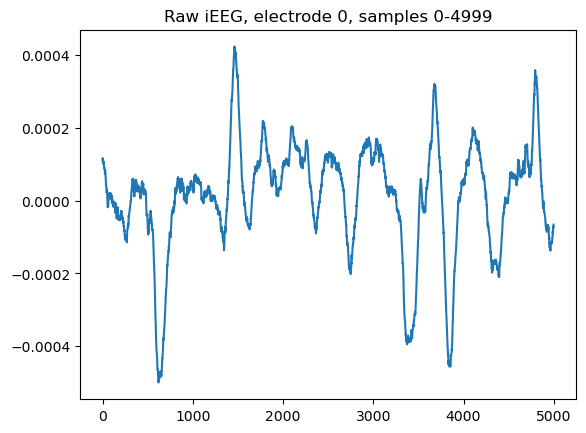

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

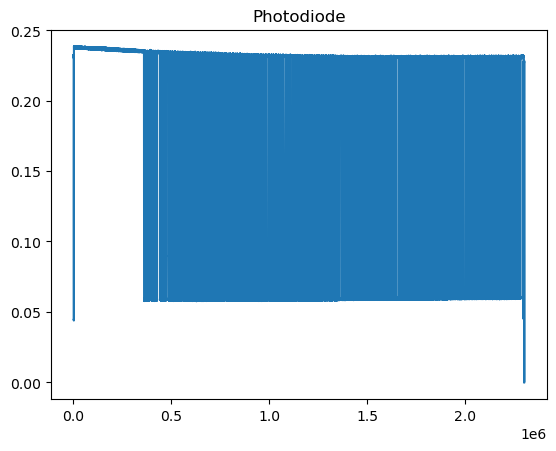

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [10]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/MS027_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Note
0,LaCaS1,A32sg_L,-1.996863,29.154473,-12.396027,-1.489100,25.800180,-10.918105,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Olfactory cortex,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS2,A32sg_L,-2.396240,31.151354,-7.997437,-2.305976,28.213844,-6.269909,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
2,LaCaS3,A32sg_L,-3.194992,33.148236,-3.198975,-3.581341,30.463378,-1.114084,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Unknown,WM,NaN
3,LaCaS4,A24rv_L,-3.594368,35.145118,1.199615,-4.402200,32.551975,3.559879,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Unknown,WM,NaN
4,LaCaS5,A24rv_L,-4.393121,37.141999,5.598206,-5.612624,34.849006,8.272237,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus F,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RHplT8,A21c_R,50.321429,-29.953224,-17.194489,58.208197,-32.244283,-9.492322,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
144,RHplT9,A21c_R,54.315191,-32.748859,-15.994873,62.645023,-35.095643,-8.145739,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
145,RHplT10,A21c_R,58.308954,-35.145117,-15.195129,67.068103,-37.522830,-7.125109,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus E,OOB,NaN
146,RHplT11,A21c_R,62.702093,-37.940751,-13.995514,71.887967,-40.228714,-5.508332,Unknown,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus E,OOB,NaN


In [11]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LiIsP1',
 'LiIsP2',
 'LiIsP3',
 'LiIsP4',
 'LiIsP5',
 'LiIsP6',
 'LiIsP7',
 'LiIsP8',
 'LiIsP9',
 'LiIsP10',
 'LiIsP11',
 'LiIsP12',
 'LiIsP13',
 'LiIsP14',
 'LiIsP15',
 'LiIsP16',
 'Lence1',
 'Lence2',
 'Lence3',
 'Lence4',
 'Lence5',
 'Lence6',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'Rm

In [12]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [13]:
unmatched_names

[]

In [14]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [15]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [16]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'LmOlF10': 'lmolf10',
 'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'RmOlF10': 'rmolf10',
 'RmOlF11': 'rmolf11',
 'RmOlF12': 'rmolf12',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'LmCmS1': 'lm

In [17]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS027_SWB.edf, 276 x 2300032 (2246.1 s), ~4.73 GB, data loaded>

In [18]:
unmatched_seeg

[]

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c157', 'c158', 'c159', 'c160', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [20]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 74 left & 74 right sEEG electrodes
We have a total of 148 sEEG electrodes


In [21]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c223',
 'c203',
 'dc11',
 'dc4',
 'c230',
 'c248',
 'c213',
 'fz',
 'c199',
 'c211',
 'f7',
 'c222',
 'pr',
 'c246',
 'c255',
 'c187',
 'c197',
 'c204',
 'trig',
 'c58',
 'c236',
 'c251',
 'dc12',
 'c220',
 'c61',
 'o2',
 'cz',
 'dc2',
 'dc5',
 'c249',
 'c245',
 'c225',
 'osat',
 'c215',
 'c235',
 'c185',
 'c189',
 'c60',
 'c186',
 'o1',
 'c195',
 'dc9',
 'f4',
 'pleth',
 'dc3',
 'c240',
 'c221',
 'pz',
 'c232',
 'c216',
 'c3',
 'c160',
 'c247',
 'c157',
 'ekg2',
 'p3',
 'c212',
 'c224',
 'c237',
 'c229',
 'c4',
 'c214',
 'c201',
 'c207',
 'f3',
 'c57',
 'c219',
 'c159',
 'f8',
 'c192',
 't3',
 'c205',
 'p4',
 'c243',
 'dc7',
 'dc8',
 'c241',
 'c234',
 'dc16',
 'c209',
 'c158',
 'c226',
 't4',
 'c239',
 'ekg1',
 'c182',
 'c183',
 'fp2',
 'c188',
 'c227',
 'c184',
 'c218',
 't5',
 'dc6',
 'c233',
 'c62',
 'c64',
 'c242',
 'c202',
 'c198',
 'c59',
 't6',
 'dc10',
 'dc14',
 'c217',
 'c208',
 'c210',
 'c193',
 'c231',
 'c256',
 'c196',
 'c228',
 'c206',
 'c238',
 'c252',
 'c253',
 'c190'

In [22]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS027_SWB.edf, 149 x 2300032 (2246.1 s), ~2.55 GB, data loaded>

In [23]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS027_SWB.edf, 149 x 2300032 (2246.1 s), ~2.55 GB, data loaded>

In [25]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS027_SWB.edf, 149 x 2300032 (2246.1 s), ~2.55 GB, data loaded>

### Notch filter line noise

In [26]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    8.5s finished


<RawEDF | MS027_SWB.edf, 149 x 2300032 (2246.1 s), ~2.55 GB, data loaded>

### Resampling Data

In [27]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:   12.8s finished


<RawEDF | MS027_SWB.edf, 149 x 1150016 (2246.1 s), ~1.28 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [28]:
mne_data.save(f'{neural_dir}/MS027/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [29]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [30]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['liisp12', 'raglt8', 'raisp11', 'raisp14', 'raisp15', 'rhplt7']

In [31]:
mne_data.info['bads'] = bads

In [32]:
mne_data.info

<Info | 10 non-empty values
 bads: 6 items (liisp12, raglt8, raisp11, raisp14, raisp15, rhplt7)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 148 sEEG
 custom_ref_applied: False
 dig: 148 items (148 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 09:35:07 UTC
 nchan: 148
 projs: []
 sfreq: 512.0 Hz
>

In [33]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [34]:
probe_names

array(['lacas', 'laglt', 'lence', 'lhplt', 'liisp', 'lmcms', 'lmolf',
       'racas', 'raglt', 'raisp', 'rhplt', 'rmcms', 'rmolf'], dtype='<U5')

In [35]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [36]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'lence': 6,
 'lhplt': 10,
 'liisp': 16,
 'lmcms': 10,
 'lmolf': 10,
 'racas': 12,
 'raglt': 12,
 'raisp': 16,
 'rhplt': 12,
 'rmcms': 10,
 'rmolf': 12}

<IPython.core.display.Javascript object>


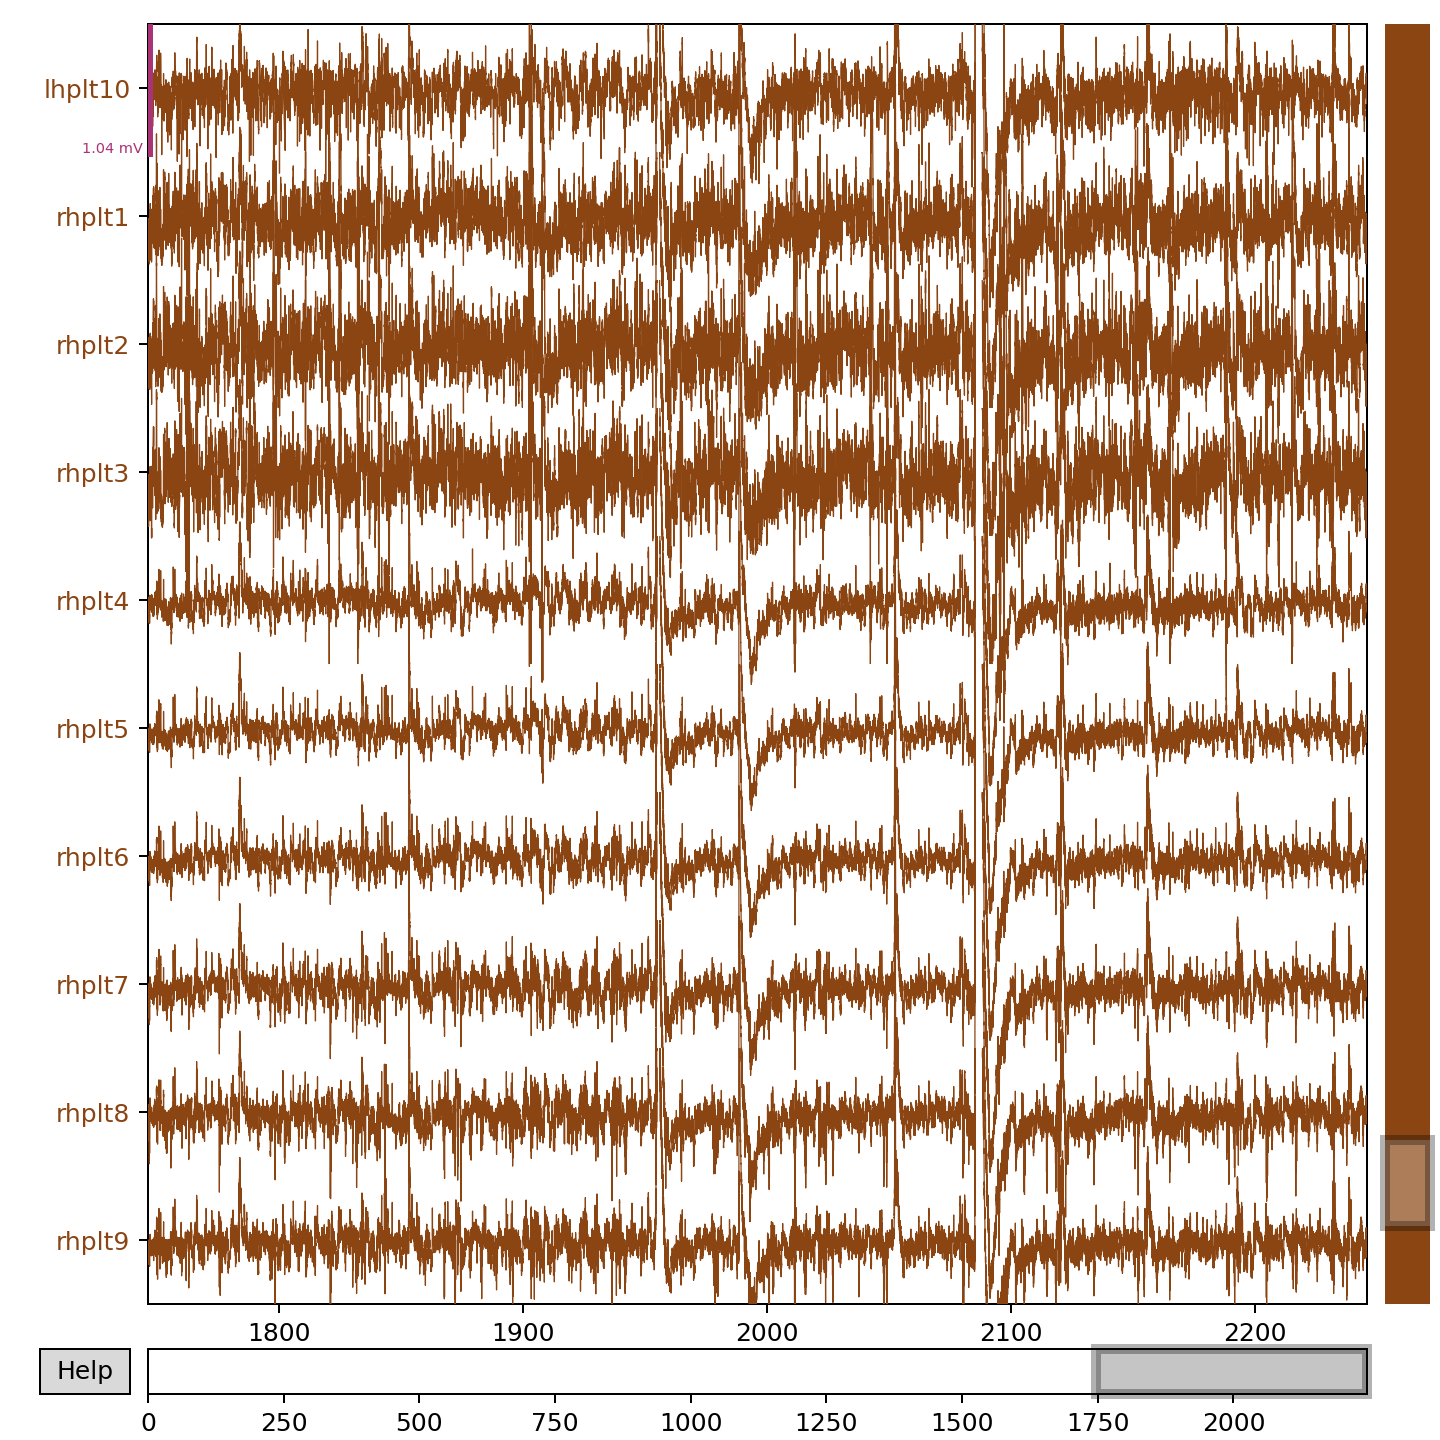

<IPython.core.display.Javascript object>


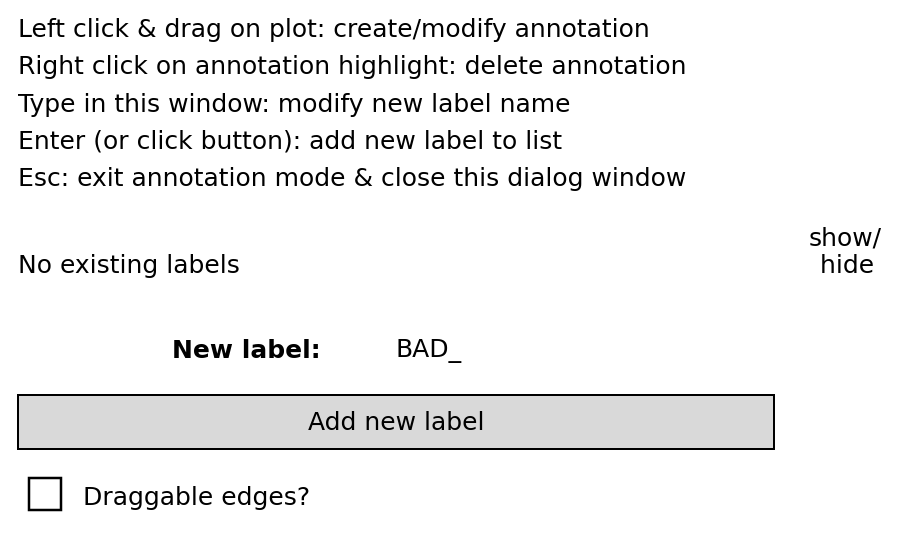

In [37]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [38]:
mne_data.info['bads']

['liisp12', 'raglt8', 'raisp11', 'raisp14', 'raisp15', 'rhplt7']

<IPython.core.display.Javascript object>


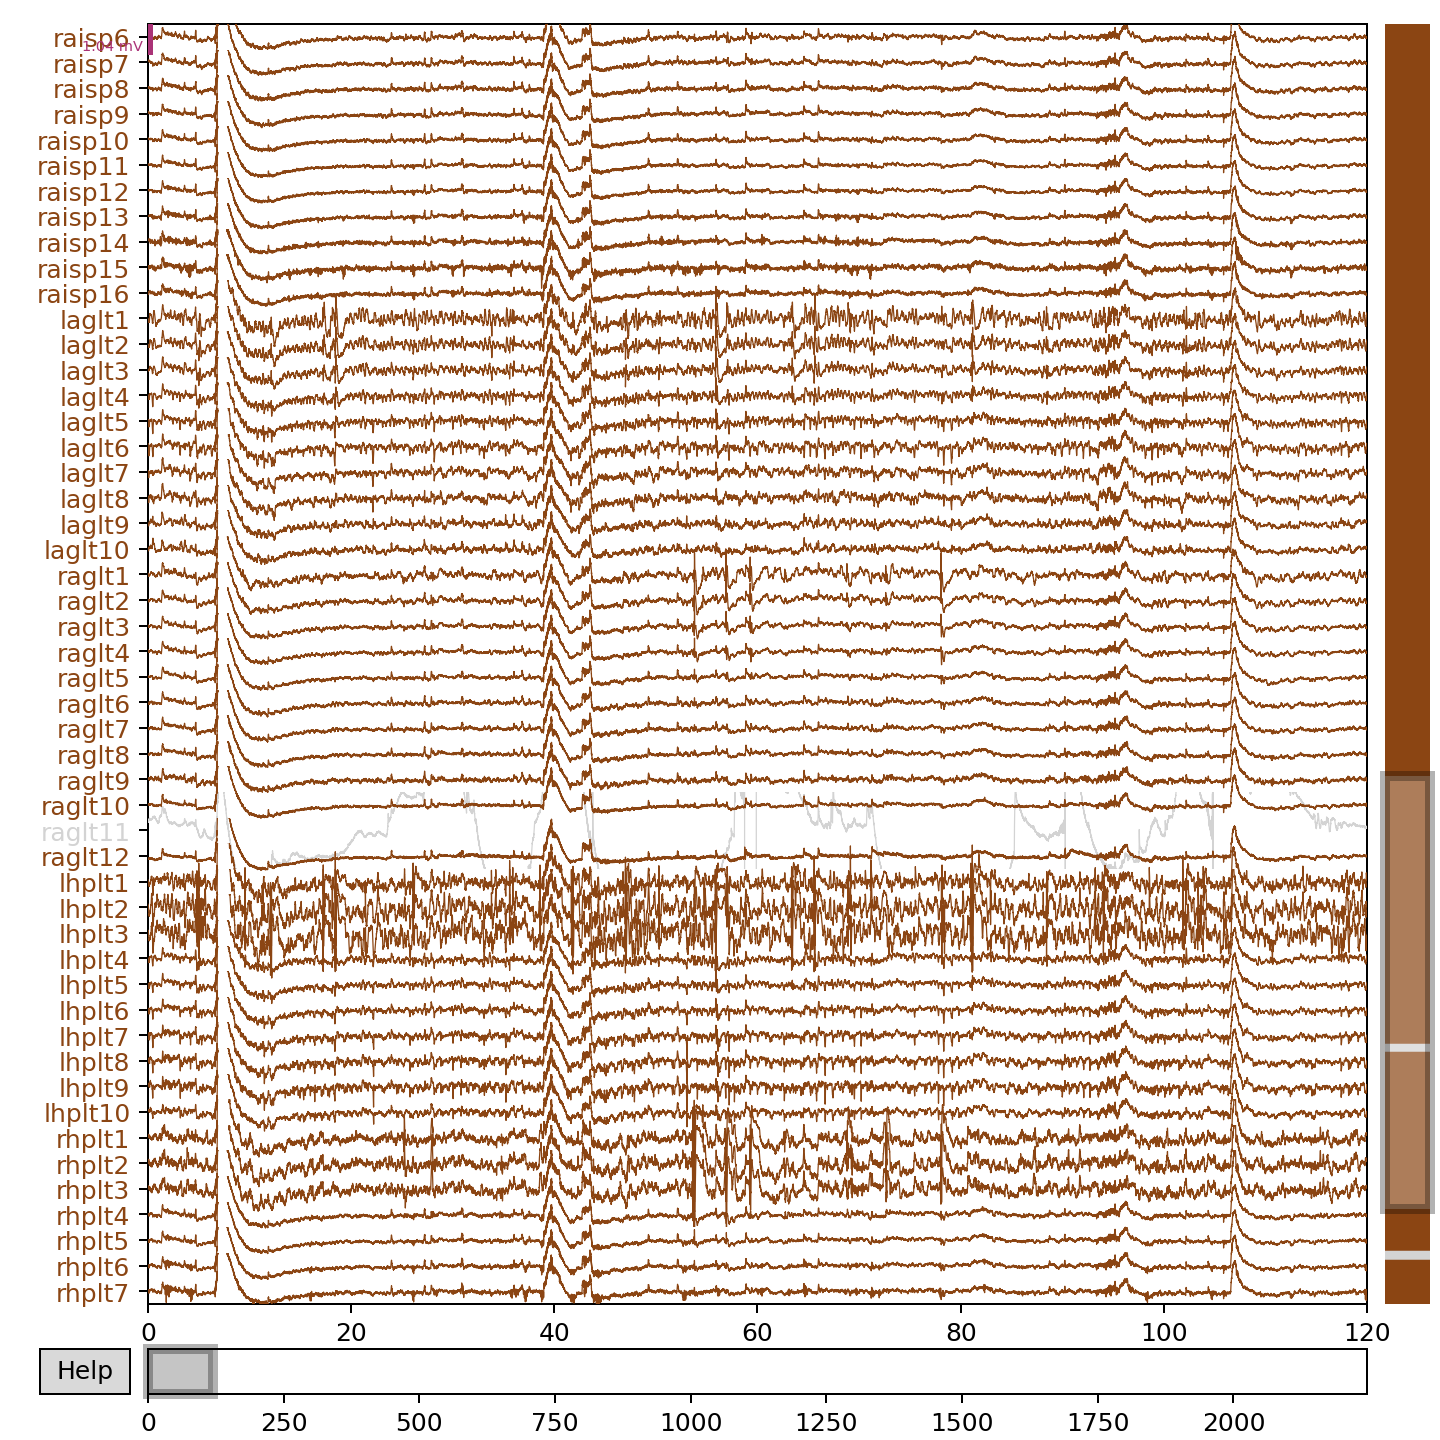

<IPython.core.display.Javascript object>


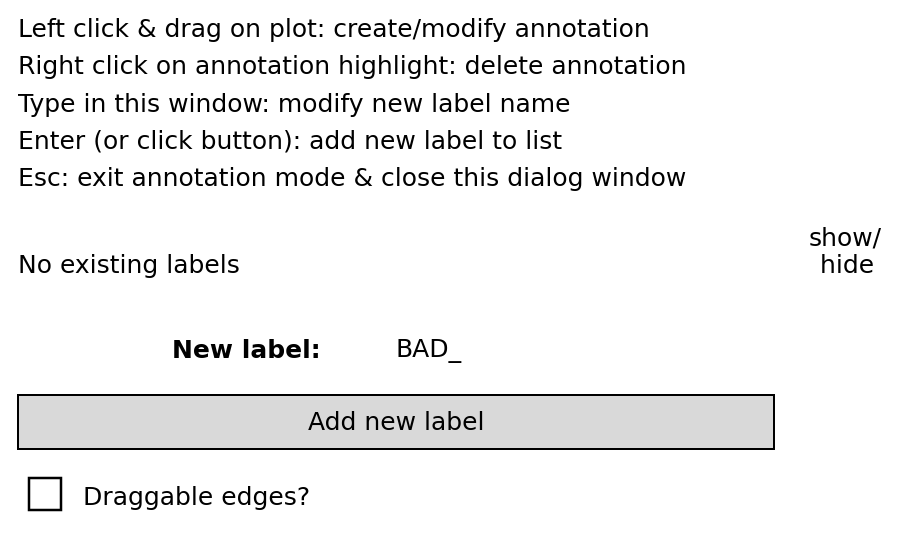

In [41]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads'] 

['lence1', 'raglt1']

In [47]:
#set bad channel info 
ms027_bad_ch = ['lence1', 'raglt11']



In [48]:
len(ms027_bad_ch)

2

In [49]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms027_bad_ch 

In [50]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (lence1, raglt11)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 148 sEEG
 custom_ref_applied: False
 dig: 148 items (148 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 09:35:07 UTC
 nchan: 148
 projs: []
 sfreq: 512.0 Hz
>

In [51]:
mne_data.info['bads'] #more sanity checking

['lence1', 'raglt11']

### Rereference data to wm electrodes

In [52]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [53]:
oob_channels

['lmcms9',
 'lmcms10',
 'lence1',
 'laglt10',
 'racas12',
 'rmcms9',
 'rmcms10',
 'rmolf11',
 'rmolf12',
 'raglt12',
 'rhplt11',
 'rhplt12']

In [54]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms027_bad_ch = ms027_bad_ch + oob_channels
ms027_bad_ch = list(np.unique(ms027_bad_ch))
mne_data.info['bads'] = ms027_bad_ch

In [55]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['laglt10',
 'lence1',
 'lmcms10',
 'lmcms9',
 'racas12',
 'raglt11',
 'raglt12',
 'rhplt11',
 'rhplt12',
 'rmcms10',
 'rmcms9',
 'rmolf11',
 'rmolf12']

In [56]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [57]:
mne_data_reref

<RawEDF | MS027_SWB.edf, 114 x 1150016 (2246.1 s), ~1000.4 MB, data loaded>

### Save cleaned continuous data

In [58]:
mne_data.save(f'{neural_dir}/MS027/lfp_data.fif',overwrite=True)

In [59]:
mne_data_reref.save(f'{neural_dir}/MS027/wm_ref_ieeg.fif',overwrite=True)